In [1]:
"IMPORT LIBRARIES AND DEFINE PATH"

import os
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics & Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Keras imports for model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.applications import MobileNetV2

output_path = "/content/drive/MyDrive/Waste Classification Project/dataset_processed"

In [2]:
"DATA AUGMENTATION AND GENERATOR SETUP"

# Custom augmentation functions
def add_noise(img):
    # Add Gaussian noise to an image.
    noise = np.random.normal(0, 0.1, img.shape)
    return np.clip(img + noise, 0, 1)

def add_blur(img):
    # Apply a mild Gaussian blur to an image.
    return cv2.GaussianBlur(img, (5, 5), 0)

def random_augmentation(img):
    """
    Applies random augmentations (noise or blur) based on image brightness.
    If the image is too dark, only a light noise is added.
    """

    # Convert image to float32 for processing
    img = np.array(img, dtype=np.float32)

    # Check brightness level
    mean_brightness = np.mean(img)

    # If image is too dark, avoid heavy augmentations
    if mean_brightness < 50:
        # For very dark images, apply minimal noise
        noise = np.random.normal(0, 5, img.shape)
        img = np.clip(img + noise, 0, 255)
    else:
        # Otherwise, randomly choose an augmentation
        choice = np.random.choice(["blur", "noise", "none"], p=[0.4, 0.4, 0.2])

        if choice == "blur":
            img = cv2.GaussianBlur(img, (3, 3), 0)
        elif choice == "noise":
            noise = np.random.normal(0, 10, img.shape)
            img = np.clip(img + noise, 0, 255)

    # Return image as float32; ImageDataGenerator's rescale will handle normalization
    return img

# Set up ImageDataGenerator for training (with augmentation)
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0,1]
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    preprocessing_function=random_augmentation  # Randomly apply noise or blur
)

# Create training generator from the "train" folder
train_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# For validation and test, only rescale (no augmentation) and disable shuffling
test_val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False
)
test_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

print("Dataset preprocessing, augmentation, and splitting completed!")

Found 5178 images belonging to 2 classes.
Found 1105 images belonging to 2 classes.
Found 1117 images belonging to 2 classes.
Dataset preprocessing, augmentation, and splitting completed!


In [3]:
"MODEL DEFINITION AND COMPILATION"

# Load the pre-trained MobileNetV2 model (without the top layers)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model layers

# Unfreeze last 70 layers of MobileNetV2 to fine-tune on our dataset
for layer in base_model.layers[-70:]:
    layer.trainable = True

# Define the final model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),      # Reduces each feature map to a single value
    Dense(128, activation='relu'), # Fully connected layer
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary output layer
])

# Compile the model using Adam optimizer and Binary Focal Crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss= BinaryFocalCrossentropy(),
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,177,537 (8.31 MB)

 Non-trainable params: 244,544 (955.25 KB)

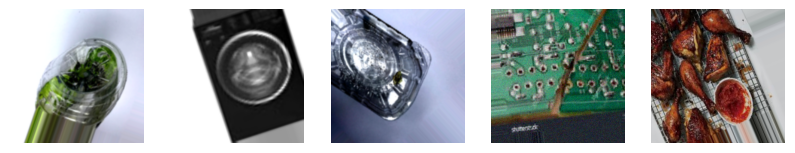

In [48]:
"VISUALIZE AUGMENTED TRAINING IMAGES"

# Retrieve one batch of augmented training images
images, labels = next(train_generator)

# Display 5 augmented images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [5]:
"TRAIN THE MODEL"

# Define EarlyStopping callback to stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=2)

# Train the model for up to 30 epochs; training may stop early if there's no improvement
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1468s 9s/step - accuracy: 0.5541 - loss: 0.2819 - precision: 0.5612 - recall: 0.5531 - val_accuracy: 0.7647 - val_loss: 0.1221 - val_precision: 0.8360 - val_recall: 0.6613
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 662s 4s/step - accuracy: 0.7158 - loss: 0.1629 - precision: 0.7189 - recall: 0.7100 - val_accuracy: 0.8679 - val_loss: 0.0830 - val_precision: 0.9098 - val_recall: 0.8180
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7838 - loss: 0.1285 - precision: 0.7730 - recall: 0.7959 - val_accuracy: 0.9041 - val_loss: 0.0636 - val_precision: 0.9463 - val_recall: 0.8577
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.8364 - loss: 0.0999 - precision: 0.8365 - recall: 0.8395 - val_accuracy: 0.9321 - val_loss: 0.0499 - val_precision: 0.9598 - val_recall: 0.9027
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.8525 - loss: 0.0915 - precision: 0.8585 - recall: 0.8484 - val_accuracy: 0.9430 - val_lo

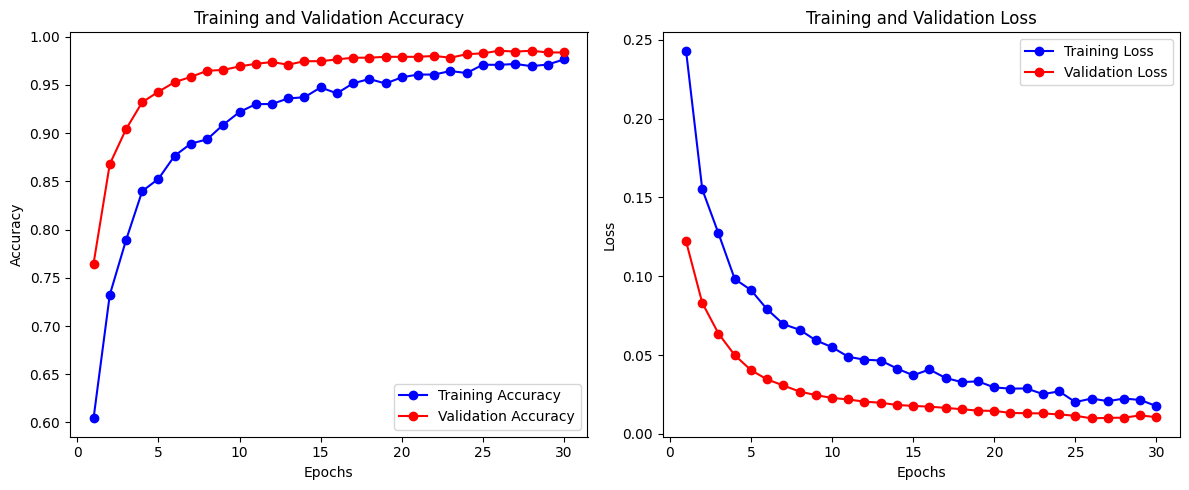

In [6]:
"""PLOT TRAINING HISTORY"""

# Extract training history metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
"""EVALUATE MODEL ON THE TEST SET"""

# Evaluate model on the test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

# Get predictions on the test set and convert probabilities to binary labels
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from the test generator
y_true = test_generator.classes

# Calculate F1 score using sklearn's f1_score
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 332s 10s/step - accuracy: 0.9849 - loss: 0.0121 - precision: 0.4943 - recall: 0.5064
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
Test Accuracy: 98.03%
F1 Score: 0.9806
Precision: 0.9806
Recall: 0.9806


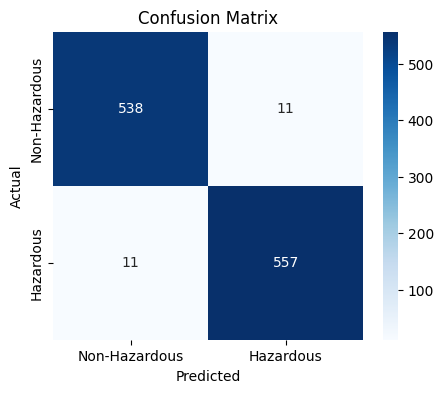

In [51]:
"""PLOT CONFUSION MATRIX"""

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Hazardous', 'Hazardous'],
            yticklabels=['Non-Hazardous', 'Hazardous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

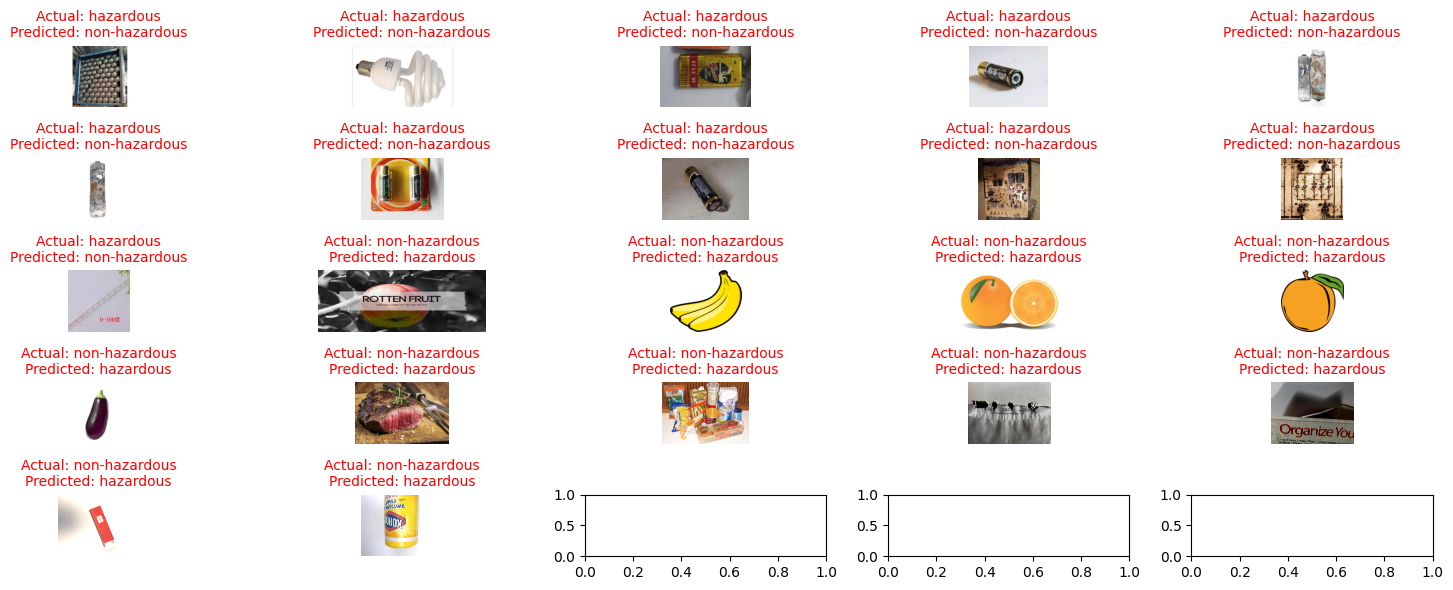

Total misclassified images: 22


In [53]:
"""VISUALIZE MISCLASSIFIED IMAGES"""

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Reset test generator to get consistent order and retrieve file paths
test_generator.reset()
y_true = test_generator.classes
file_paths = test_generator.filepaths

# Flatten predictions for comparison
y_pred = y_pred.flatten()

# Identify misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

if len(misclassified_indices) == 0:
    print("No misclassified images found.")
else:
  # Display some misclassified images
  num_images = min(22, len(misclassified_indices))  # Show up to 10 misclassified images
  fig, axes = plt.subplots(5, 5, figsize=(15, 6))  # Create a grid for images

  for i, ax in enumerate(axes.flat[:num_images]):
      idx = misclassified_indices[i]
      img = plt.imread(file_paths[idx])

      ax.imshow(img)
      ax.axis("off")
      ax.set_title(f"Actual: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred[idx]]}",
                  fontsize=10, color='red')

plt.tight_layout()
plt.show()
print(f"Total misclassified images: {len(misclassified_indices)}")

In [10]:
"""CHECK PREDICTION DISTRIBUTION"""
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(549), np.int64(1): np.int64(568)}

In [15]:
""" SAVE THE MODEL"""

# Save the trained model to Google Drive
model.save('/content/drive/MyDrive/Waste Classification Project/model/ModelV8.keras')

print("Model saved successfully!")

Model saved successfully!
